Experiment outline:
Let L be a list of penalties for glasso. For each entry b in L:
1) Run glasso on an empirical covariance matrix with penalty b
2) Use the estimated graph from step 1) to solve for an unpenalized MLE using IPS and NCD
3) Compare results from 1) to 2)

# Imports

In [179]:
import numpy as np
from sklearn.covariance import  graphical_lasso

import numpy as np
from cov_selection.common import S
from cov_selection.Graph import Graph, RandomGraph
from cov_selection.ncd import NCD
from cov_selection.ips import IPS

from matplotlib import pyplot as plt
import time
import networkx as nx
import os

# Setup

In [180]:
def con_and_time(s, a):
    print(f"penalty={a}")
    # compute glasso
    start = time.time()
    cov_glasso, con_glasso = graphical_lasso(s, alpha=a, max_iter=1000, mode='cd')
    time_glasso = time.time() - start
    # extract the graph from glasso
    g = Graph(adj=(con_glasso != 0 ).astype(int))
    start = time.time()
    cov_ncd = NCD(s,g,100)
    time_ncd = time.time() - start
    start = time.time()
    cov_ips, con_ips = IPS(s, g, 100)
    time_ips = time.time() - start
    return np.array([cov_glasso, cov_ncd, cov_ips]), np.array([time_glasso, time_ncd, time_ips])

In [181]:
def experiment(penalties, s):
    results = []
    times = []
    for a in penalties:
        res, t = con_and_time(s, a)
        results.append(res)
        times.append(t)
    results = np.array(results)
    times = np.array(times)
    return results, times

In [182]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

In [183]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
save_experiment = False
if save_experiment:
    dir_name = f"{int(time.time())}"
    if not os.path.exists("results/"+dir_name):
        os.mkdir("results/"+dir_name)
    save_dir = f"results/{dir_name}/"
# seeds = [0, 42, 100]
seed = 0
np.random.seed(seed)

# Generate Random Graph

In [184]:
n=50
G = RandomGraph(n=n, graph_structure='watts_strogatz', k=8, p=0.5, d=0.05, seed=seed)
print(G)
sampling_size = 200
s = np.cov(G.sample(sampling_size), rowvar=False, bias=False)
print(f"K positive definite? {is_positive_definite(G.con)}")
print(f"Sigma positive definite? {is_positive_definite(G.cov)}")

G($|V|$=50, WS(k=8,p=0.5))
K positive definite? True
Sigma positive definite? True


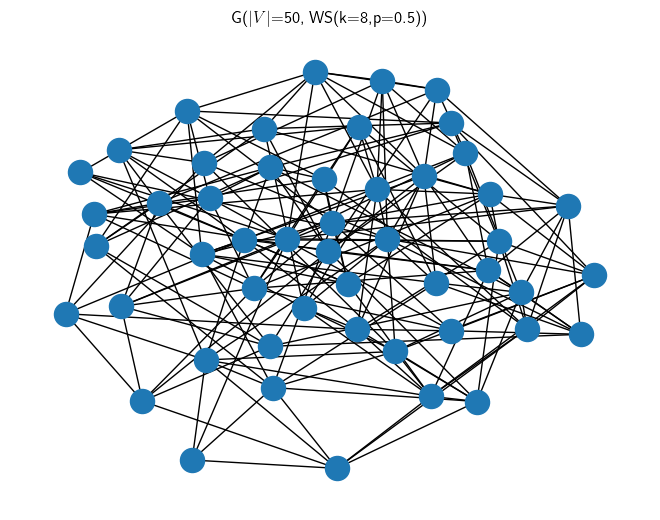

In [185]:
nx.draw(G.graph_structure)
plt.title(f"{G}")
if save_experiment:
    plt.savefig(save_dir+"graph_structure.png")
plt.show()

# Plot absolute value of odd-diagonal entries

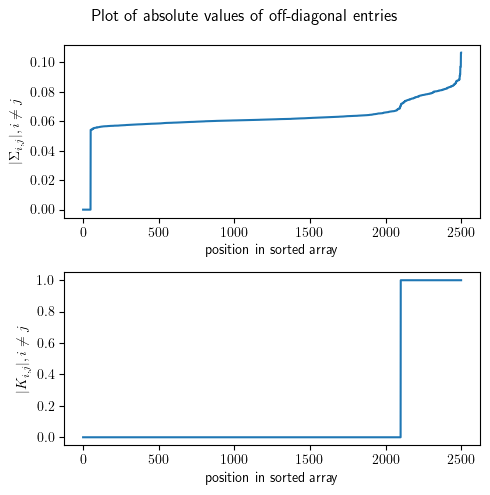

In [186]:
matrix = np.ones((G.n, G.n))  # Create an n x n matrix filled with 1s
np.fill_diagonal(matrix, 0)
#  rho plot
fig, ax = plt.subplots(2, figsize=(5,5))
plt.rcParams['text.usetex'] = True
fig.suptitle(f"Plot of absolute values of off-diagonal entries")
y = np.sort((np.abs(G.cov*matrix).flatten()))
x = np.arange(len(y))
ax[0].plot(x, y)
ax[0].set_ylabel(r"$|\Sigma_{i,j}|, i \neq j$")
ax[0].set_xlabel(r"position in sorted array")

y = np.sort((np.abs(G.con*matrix).flatten()))
x = np.arange(len(y))
ax[1].plot(x, y)
ax[1].set_ylabel(r"$|K_{i,j}|, i \neq j$")
ax[1].set_xlabel(r"position in sorted array")
#ax[1].set_title(r"Rho plot of $K$")

plt.tight_layout()
if save_experiment:
    plt.savefig(f"{save_dir}rho_plot.png")

# Experiment

In [70]:
penalties = np.array([0,1e-6,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1, 10])
res, t = experiment(penalties, s)

penalty=0.0
penalty=1e-06
penalty=1e-05
penalty=0.0001
penalty=0.001
penalty=0.01
penalty=0.1
penalty=1.0
penalty=10.0


In [71]:
# compute oracle estimators 
ips_oracle_sigma, ips_oracle_k = IPS(s, G, 200)
ncd_oracle = NCD(s, G, 100)

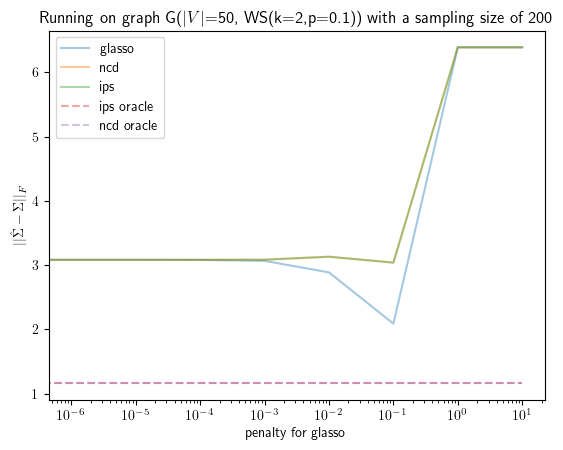

In [72]:
#norm = lambda pred, true : batch_kl_divergence_covariance(pred, true)
norm = lambda pred, true: np.linalg.norm(pred - true, ord='fro', axis=(1,2)) 
glasso_normed = norm(res[:,0,:,:],  G.cov)
ncd_normed = norm(res[:,1,:,:], G.cov)
ips_normed = norm(res[:,2,:,:], G.cov)

# Plot
fig,ax = plt.subplots()
plt.rcParams['text.usetex'] = True
# plot results
ax.plot(penalties, glasso_normed, label=f"glasso", alpha=0.4)
ax.plot(penalties, ncd_normed, label=f"ncd", alpha=0.4)
ax.plot(penalties, ips_normed, label=f"ips", alpha=0.4)
ax.plot(penalties, norm(np.array([ips_oracle_sigma for p in penalties]), G.cov), alpha=0.4, linestyle="dashed", label=f"ips oracle")
ax.plot(penalties, norm(np.array([ncd_oracle for p in penalties]), G.cov), alpha=0.4, linestyle="dashed", label=f"ncd oracle")

ax.set_xscale('log')
ax.set_xlabel("penalty for glasso")
ax.set_ylabel(r"$||\hat \Sigma - \Sigma||_F$")

ax.legend()
plt.title(f"Running on graph {G} with a sampling size of {sampling_size}")
if save_experiment:
    plt.savefig(f"{save_dir}sigma.png")


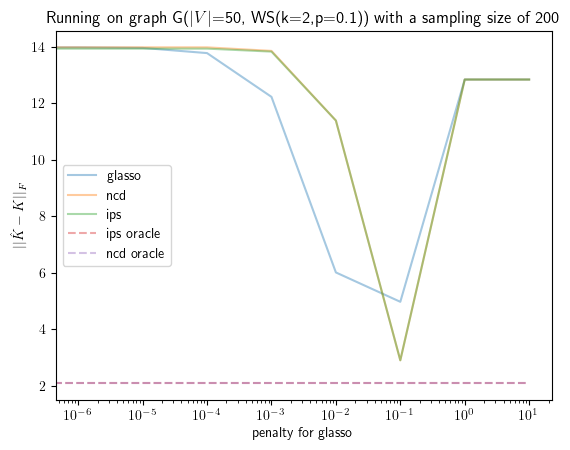

In [73]:
glasso_normed = norm(np.linalg.inv(res[:,0,:,:] ),  G.con)
ncd_normed = norm(np.linalg.inv(res[:,1,:,:]), G.con)
ips_normed = norm(np.linalg.inv(res[:,2,:,:]), G.con)

# Plot
fig,ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.plot(penalties, glasso_normed, label=f"glasso", alpha=0.4)
ax.plot(penalties, ncd_normed, label=f"ncd", alpha=0.4)
ax.plot(penalties, ips_normed, label=f"ips", alpha=0.4)
ax.plot(penalties, norm(np.array([ips_oracle_k for p in penalties]), G.con), alpha=0.4, linestyle="dashed", label=f"ips oracle")
ax.plot(penalties, norm(np.linalg.inv(np.array([ncd_oracle for p in penalties])), G.con), alpha=0.4, linestyle="dashed", label=f"ncd oracle")
ax.set_xscale('log')
ax.set_xlabel("penalty for glasso")
ax.set_ylabel(r"$||\hat K - K||_F$")

ax.legend()
plt.title(f"Running on graph {G} with a sampling size of {sampling_size}")
if save_experiment:
    plt.savefig(f"{save_dir}k.png")

# Timing

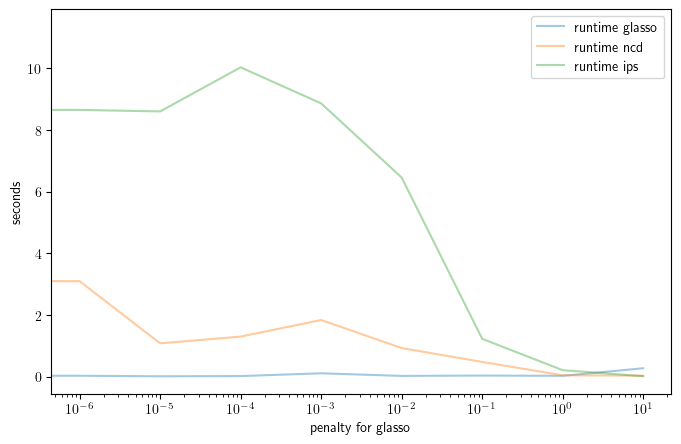

In [74]:
time_glasso = t[:,0]
time_ncd = t[:,1]
time_ips = t[:,2]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(penalties, time_glasso, label=f"runtime glasso", alpha=0.4)
ax.plot(penalties, time_ncd, label=f"runtime ncd", alpha=0.4)
ax.plot(penalties, time_ips, label=f"runtime ips", alpha=0.4)

ax.set_ylabel(f"seconds")
ax.set_xlabel(f"penalty for glasso")
ax.set_xscale('log')

ax.legend(loc='upper right')
if save_experiment:
    plt.savefig(f"{save_dir}time.png")